In [9]:
%load_ext line_profiler

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numba import jit

def Read(filename):
    pos = []
    with open(filename) as f:
        lines = f.readlines()
        for line in lines:
            sub_line = line.split(" ", -1)
            if(sub_line[0].isdigit()):
                pos.append([int(sub_line[1]), int(sub_line[2])])
    return len(pos), np.array(pos)

def CityDistance(city_coordinates, N):
    city_distance = np.zeros((N, N), dtype = np.float32)
    vx, vy = 14.5, 42
    tx, ty = 0, 0
    coor_x_tmp1 = city_coordinates[:, 0].reshape(-1,1) * np.ones((1, N))
    coor_x_tmp2 = coor_x_tmp1.transpose()
    coor_y_tmp1 = city_coordinates[:, 1].reshape(-1,1) * np.ones((1, N))
    coor_y_tmp2 = coor_y_tmp1.transpose()

    lx = abs(coor_x_tmp1 - coor_x_tmp2)/vx + tx
    ly = abs(coor_y_tmp1 - coor_y_tmp2)/vy + ty
    lx[lx == tx]=0
    ly[ly == ty]=0
    city_distance = np.where(lx>ly, lx, ly)
    return city_distance

def dijkstra(a, sb):
    n = a.shape[0]
    a = a.copy()
    visited = np.zeros(n, dtype = np.bool)
    visited[sb] = 1
    path = np.zeros(n, dtype = np.int)
    path[0] = sb
    for i in range(n-1):
        q = a[sb,:]
        q[visited] = np.inf
        location = np.argmin(q)
        path[i+1] = location
        visited[location] = True
        sb = location
    return path

def GroupFit(city_distance, N, pop, s):
    pop = pop.copy().astype(int)
    individual_distance = np.sum(city_distance[pop[:, np.arange(N-1)], pop[:, np.arange(1, N)]], axis = 1) + city_distance[pop[:,N-1], pop[:,0]]
    a = np.argmin(individual_distance)
    min_distance = individual_distance[a]
    individual_fit=1./individual_distance
    num = np.sum(individual_fit)
    return individual_fit, num, min_distance, a

def ChooseParents(pop, pop1, N, s, c):
    pop, pop1 = pop.copy(), pop1.copy()
    pop = pop[np.argsort(pop[:, -1])[::-1], :]
    pop1 = pop1[np.argsort(pop1[:,-1])[::-1], :]
    pop2 = np.r_[pop1[:int(s*(1-c)),:],pop[:int(s*c),:]]
    randInd = np.random.permutation(pop2.shape[0])
    return  pop2[randInd,:]

def CrossVariation(pop1, pop2, crosspoint, N):
    crossoverPoint1, crossoverPoint2 = np.min(crosspoint), np.max(crosspoint)
    child1, child2 = -1*np.ones(N+1, dtype = np.float32), -1*np.ones(N+1, dtype = np.float32) 
    child1[crossoverPoint1:crossoverPoint2] = pop1[crossoverPoint1:crossoverPoint2]
    child2[crossoverPoint1:crossoverPoint2] = pop2[crossoverPoint1:crossoverPoint2]
    for t in pop2[crossoverPoint1:crossoverPoint2]:
        if t not in pop1[crossoverPoint1:crossoverPoint2]:
            ind = np.where(pop2[:-1] == t)[0]
            while crossoverPoint1 <= ind and ind < crossoverPoint2:
                temp = pop1[ind]

                ind = np.where(pop2[:-1] == temp)[0]
            child1[ind] = t

    ind = np.where(child1 == -1)[0]
    child1[ind] = pop2[ind]
    
    for t in pop1[crossoverPoint1:crossoverPoint2]:
        if t not in pop2[crossoverPoint1:crossoverPoint2]:
            ind = np.where(pop1[:-1] == t)[0]
            while crossoverPoint1 <= ind and ind < crossoverPoint2:
                temp = pop2[ind]
                ind = np.where(pop1[:-1] == temp)[0]
            child2[ind] = t

    ind = np.where(child2 == -1)
    child2[ind] = pop1[ind]
    child1[-1], child2[-1] = pop1[-1], pop2[-1]
    return np.array(child1), np.array(child2)

def Mutation(pop0, N):
    pop0 = pop0.copy()
    crosspoint = np.random.randint(0, N, 2)
    min_cross, max_cross = np.min(crosspoint), np.max(crosspoint)
    pop0[min_cross:max_cross] = np.flip(pop0[min_cross:max_cross])
    return pop0

def DrawPath(city_coordinate, E_new_new, N):
    k = E_new_new[:N].astype(int)
    plt.scatter(city_coordinate[:,0], city_coordinate[:,1], marker = '*', c ='red')
    for i in range(N-1):
        plt.plot([city_coordinate[k[i], 0], city_coordinate[k[i+1], 0]], [city_coordinate[k[i],1], city_coordinate[k[i+1], 1]])
    plt.xlabel('X/mm')
    plt.ylabel('Y/mm')
    plt.box(False)
    plt.show()


In [41]:
from numba import cuda

@cuda.jit('void(float32[:,:], int32[:,:])')
def Mutation_cuda(pop0, crosspoint):
    tid = cuda.threadIdx.x
    min_cross, max_cross = crosspoint[tid, 0], crosspoint[tid, 1]
    i, j = min_cross, max_cross
    while(j>i):
        temp = pop0[tid, i]
        pop0[tid, i] = pop0[tid, j]
        pop0[tid, j] = temp
        i += 1
        j -= 1

@cuda.jit('void(float32[:,:], int32, float32[:,:], int32, float32[:])')
def GroupFit_cuda(city_distance, N, pop, s, pop_min):
    tid = cuda.threadIdx.x
    pop[tid, N] = 0
    for i in range(N):
        pop[tid, N] += city_distance[int(pop[tid, i]), int(pop[tid, (i+1)%N])]
    
    pop[tid, N] = 1/pop[tid,N]

    for i in range(s):
        if pop[i, N]>pop_min[N]:
            pop_min = pop[i,:]




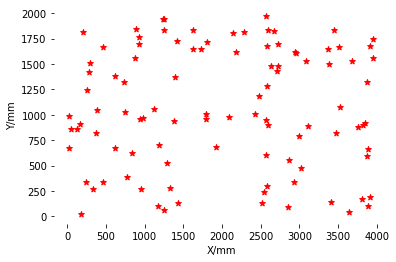

In [42]:
def check_valid(pop):
    pop = pop.copy()
    pop.sort()
    print(pop.astype(int), np.arange(100))
    return (pop.astype(int) == np.arange(100)).all()

def find_shortes_path(pop, individual_fit, times, s, c, pm, pc, N, city_distance, sum, sum_P, min_dis, city_coordinates):
    min_dis, pop_min = np.array(min_dis, dtype = np.float32), np.zeros(N+1, dtype = np.float32)
    d_city_distance, d_individual_fit, d_min_dis, d_pop_min = cuda.to_device(city_distance.astype(np.float32)), cuda.to_device(individual_fit.astype(np.float32)), cuda.to_device(min_dis.astype(np.float32)), cuda.to_device(pop_min.astype(np.float32))

    for time in range(times):
        # print(time)
        pop5 = pop.copy()
        min11 = np.min(individual_fit)
        a = np.random.randn(s//2)
        bj = np.where(individual_fit[:s//2]<individual_fit[s//2:], individual_fit[:s//2], individual_fit[s//2:])
        for j in range(s//2):
            
            if bj[j]<=sum/s:
                pc1 = pc*(bj[j]-min11)/(sum/s-min11)
            else:
                pc1 = pc
            if a[j]<=pc1:
                crosspoint = np.random.randint(0, N, 2)
                pop[j,:], pop[j+s//2,:] = CrossVariation(pop[j,:], pop[j+s//2,:], crosspoint, N)

        b, crosspoint = np.random.randn(s), np.random.randint(0, N, (s, 2), dtype = np.int32)
        crosspoint = np.sort(crosspoint, axis = 1)
        bj = individual_fit
        pm1 = np.where(bj<=sum/s, pm*(individual_fit-min11)/(sum/s-min11), pm)
        d_pop, d_crosspoint = cuda.to_device(pop), cuda.to_device(crosspoint)
        Mutation_cuda[[1, 1, 1], [100, 1, 1]](d_pop, d_crosspoint)

        GroupFit_cuda[[1, 1, 1], [100, 1, 1]](d_city_distance,N,d_pop,s,d_pop_min)
        cuda.synchronize()
        pop = d_pop.copy_to_host()

        pop = ChooseParents(pop5, pop, N, s, c)

    pop_min = d_pop_min.copy_to_host()
    DrawPath(city_coordinates, pop_min, N)

filepath = "./TSPlib/kroA100.tsp"
s, c,pc, pm, times = 100, 0.2, 0.9, 0.2, 10000
N, city_coordinates = Read(filepath)
city_distance = CityDistance(city_coordinates, N)
pop = np.zeros((s, N+1), dtype = np.float32)
for i in range(s):
    sb = np.random.randint(0, N)
    pop[i,:-1] = dijkstra(city_distance, sb)
    # pop[i, :-1] = np.random.permutation(100)

individual_fit,sumP,min_dis,min_index=GroupFit(city_distance, N, pop, s)
sum = sumP
pop[:,-1] = individual_fit
pop_min = pop[min_index]
find_shortes_path(pop, individual_fit, times, s, c, pm, pc, N, city_distance, sum, sumP, min_dis, city_coordinates)
# find_shortes_path(pop, individual_fit, times, s, c, pm, pc, N, city_distance, min_dis, city_coordinates)

In [15]:
fitness = 0
for i in range(99):
    fitness += 1.0/((city_coordinates[int(pop_min[i]), 0]+city_coordinates[int(pop_min[i+1]), 0])**2 + (city_coordinates[int(pop_min[i]), 1]+city_coordinates[int(pop_min[i+1]), 1])**2)
print(fitness)

1.2444573684755664e-05
